In [26]:
import numpy as np
import pandas as pd
import os
import sklearn
from csv import DictWriter
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset_folder_path = './Dataset'

Dataset used for this code is available here : http://www.win.tue.nl/~mpechen/projects/smm/


In [3]:
def create_dataset_csv(folder_path):
  '''
  Creates a csv from a folder directory structure
  Input: 
    folder_path - Path to folder of dataset. 
  '''
  field_names = ['text','language']
  processed_count = 0
  csv_object = open(os.path.join('./Dataset','lid_dataset.csv'), 'a')
  dictwriter_object = DictWriter(csv_object, fieldnames=field_names)
  for _file in os.listdir(folder_path): 
    for txt_file_path in os.listdir(os.path.join(folder_path,_file)):
      txt_file_object = open(os.path.join(folder_path,_file,txt_file_path),'r')
      if processed_count % 100 == 0:
        print(processed_count)
      text_content = txt_file_object.read() 
      dictwriter_object.writerow({
          'text':text_content,
          'language':_file
      })
      processed_count += 1

  csv_object.close()
# create_dataset_csv(dataset_folder_path)

In [4]:
csv_path = './Dataset/lid_dataset.csv'
dataset = pd.read_csv(csv_path)
dataset.columns = ['text','language']
dataset.head(10)

,text,language
0,winter storm taking aim at southeast,en_UK
1,toure ready to show credentials yaya toure bel...,en_UK
2,cnn fact check paying for that sputnik moment,en_UK
3,the taliban in pakistan weve got a bigger prob...,en_UK
4,bbc reporter people in cornwall make compariso...,en_UK
5,have a look here this should be useful,en_UK
6,hundreds die in cambodia stampede,en_UK
7,any luck chris let us know if you need any help,en_UK
8,o2 gets better connected on carbon,en_UK
9,coyle compiles referee dvd bolton manager owen...,en_UK


The dataset consists of 6 languages: <br> 
de_DE - German <br>
en_UK - English <br>
es_ES - Spanish <br>
fr_FR - French <br>
it_IT - Italian <br>
nl_NL - Dutch <br>

In [5]:
lang_mapping = {
'de_DE':'German',
'en_UK':'English',
'es_ES':'Spanish',
'fr_FR':'French',
'it_IT':'Italian',
'nl_NL':'Dutch' 
}

dataset = dataset.replace({"language": lang_mapping},inplace=False)

In [6]:
dataset['language'].value_counts()

Italian    7695
French     7583
English    7524
Spanish    2595
German     1479
Dutch      1430
Name: language, dtype: int64

In [7]:
train_df_list = []
test_df_list = []
languages = dataset['language'].unique()
for language in languages:
  train_df_list.append(dataset[dataset['language'] == language][:1200])
  test_df_list.append(dataset[dataset['language'] == language][1200:1400])

train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

print("Training dataset size: ",len(train_df))
print("Testing dataset size: ",len(test_df))

Training dataset size:  7200
Testing dataset size:  1200


In [8]:
def convert_to_ngrams(text,n):
  '''
  Converts to text to an n-gram list.
  Input: 
    text - String input
    n - number of characters per n-gram.
  Output:
  '''
  text = text.replace(' ','.')
  text = [text[i:i+n] for i in range(len(text)-n)]
  return text

train_df['n-gram'] = train_df['text'].apply(lambda x:convert_to_ngrams(x,3))
test_df['n-gram'] = test_df['text'].apply(lambda x:convert_to_ngrams(x,3))

train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)

print(train_df['language'].value_counts())
print(test_df['language'].value_counts())

Spanish    1200
Dutch      1200
German     1200
French     1200
Italian    1200
English    1200
Name: language, dtype: int64
Dutch      200
German     200
Italian    200
French     200
English    200
Spanish    200
Name: language, dtype: int64


In [9]:
class Vertex:
  '''
    A class to represent vertices in the graph.
  '''
  def __init__(self,node,languages):
    self.id = node
    self.adjacent = {}
    self.languages = languages 
    # This dictionary keeps track of the frequency of the current n-gram text for all languages.
    self.languages_dict = {language:0 for language in self.languages} 
  
  def __str__(self):
    return str(self.id) + ' adjacent: ' + str([x.id for x in self.adjacent])
  
  def add_neighbour(self,vertex,weight):
    '''
    Used to add a neighbour vertex or to update the weight between vertices
    Input:
      vertex - vertex which is to be added.
      weight - A dictionary which represents the edge weight between two vertices.
    '''
    self.adjacent[vertex] = weight
  
  def get_edge_weights(self,to_vertex):
    '''
    Used to get edge weights
    '''
    return self.adjacent[to_vertex]
  
  def update_weight(self,language):
    '''
    Used to update weight for a language of the current vertex. 
    '''
    self.languages_dict[language] += 1
  

In [10]:
class Graph:
  '''
    A class to represent the entire corpus of training data. 
  '''
  def __init__(self,languages):
    self.vertices_dictionary = {}
    self.total_vertices = 0
    self.languages = languages
    # This dictionary is used to initialize edge weights. 
    self.languages_dict = {language:0 for language in self.languages} 

  def __iter__(self):
    return iter(self.vertices_dictionary.values())
  
  def add_vertex(self,node):
    '''
    Used for adding a vertex to the graph.
    '''
    self.total_vertices += 1
    new_vertex = Vertex(node,languages)
    self.vertices_dictionary[node] = new_vertex
    return new_vertex
  
  def get_vertex(self,node):
    '''
    Used to return a vertex from the graph. Returns false if vertex is not present.
    '''
    if self.vertices_dictionary.get(node):
      return self.vertices_dictionary[node]
    else:
      return None

  def check_edge(self,from_vertex,to_vertex):
    '''
    Used to check if edge is present in the graph between two vertices.
    '''
    if not self.vertices_dictionary.get(from_vertex): 
      return False

    if not self.vertices_dictionary.get(to_vertex): 
      return False

    if self.vertices_dictionary[from_vertex].adjacent.get(to_vertex):
      return True 
    return False

  def add_edge(self,from_vertex,to_vertex,cost = None):
    '''
    Used to add an edge between two vertices. 
    '''
    if not cost:
      cost = self.languages_dict

    if not self.vertices_dictionary.get(from_vertex):
      self.add_vertex(from_vertex)
    if not self.vertices_dictionary.get(from_vertex):
      self.add_vertex(to_vertex)
    
    self.vertices_dictionary[from_vertex].add_neighbour(self.vertices_dictionary[to_vertex],cost)

# Training Algorithm


In [11]:
def build_graph(x,y):
  '''
  Used to build a model from the corpus.
  Input:
    x - List of n-gram data points.
    y - List of labels for the data points.
  Output:
    model - A Graph which is trained on the corpus.
  '''
  model = Graph(y.unique())
  for text,language in zip(x,y):
    # Update Vertex weights
    for i,word in enumerate(text):
      if model.get_vertex(word):
        # Update word's language dict
        model.vertices_dictionary[word].update_weight(language)
      else:
        # Add word to graph with a language dictionary
        model.add_vertex(word)
        model.vertices_dictionary[word].update_weight(language)

    # Update edge weights
    for i in range(1,len(text)):
      if model.get_vertex(text[i]):
        # Update previous node's and current node's language weight
        prev_node = text[i-1]
        if model.check_edge(prev_node,text[i]):
          edge_weights = model.vertices_dictionary[prev_node].get_edge_weights(text[i])
          edge_weights[language] += 1
          model.vertices_dictionary[prev_node].add_neighbour(text[i],edge_weights)
        else:
          # If there is no edge between previous node and current node. 
          curr_language_dict = {lang:0 for lang in model.languages}
          curr_language_dict[language] = 1
          model.add_edge(text[i-1],text[i],curr_language_dict)
  
  return model    


model = build_graph(train_df['n-gram'],train_df['language'])

# Inference algorithm

In [12]:
def evaluate_sentence(model,x,y):
  '''
  Function used to evaluate a text.
  '''
  # This dictionary calculates path matching scores for each language. 
  path_matching_dict = {lang:0 for lang in model.languages}
  
  # We calculate the sum of all edge weights and sum of all vertex weights which
  # will be used to normalize score for inference on test data point.
  vertex_normalizing_scores = 0
  edge_normalizing_scores = 0
  for vertex in model.vertices_dictionary.values():
    for score in vertex.languages_dict.values():
      vertex_normalizing_scores += score

    for edge_weights in vertex.adjacent.values():
      for weight in edge_weights.values():
        edge_normalizing_scores += weight
    
  for test_vertex in x:
    if model.get_vertex(test_vertex):
      model_vertex = model.get_vertex(test_vertex)
      for lang,weight in model_vertex.languages_dict.items():
        path_matching_dict[lang] += (weight / vertex_normalizing_scores)
  
  for i in range(1,len(x)):
    prev_node = x[i-1]
    if model.check_edge(prev_node,x[i]):
      edge_weights = model.vertices_dictionary[prev_node].get_edge_weights(x[i])
      for lang,weight in edge_weight.items():
        path_matching_dict[language] += (weight / edge_normalizing_scores)
  
  # We calculate the max value from our calculated scores.
  predicted_lang = max(path_matching_dict, key=path_matching_dict.get)
  
  return predicted_lang,y

In [13]:
import sys
import pickle

# sys.setrecursionlimit(50000)
# pickle.dump(model,open('./liga_model.pkl','wb'))
# model = pickle.load(open('./liga_model.pkl','rb'))

In [14]:
test_df[test_df['language']=='Italian']

,text,language,n-gram
2851,una interessante hashtag da seguire nei prossi...,Italian,"[una, na., a.i, .in, int, nte, ter, ere, res, ..."
2862,il cairo esercito separa oppositori e sostenit...,Italian,"[il., l.c, .ca, cai, air, iro, ro., o.e, .es, ..."
2781,si avvicina la pausa natalizia il momento idea...,Italian,"[si., i.a, .av, avv, vvi, vic, ici, cin, ina, ..."
2871,grazie per la risposta ma allora ti chiedo se ...,Italian,"[gra, raz, azi, zie, ie., e.p, .pe, per, er., ..."
2822,ho pubblicato 13 foto su facebook nellalbum li...,Italian,"[ho., o.p, .pu, pub, ubb, bbl, bli, lic, ica, ..."
...,...,...,...
2798,ecco in esclusiva per il web i primi 2 minuti ...,Italian,"[ecc, cco, co., o.i, .in, in., n.e, .es, esc, ..."
2771,la sfida più grande tra gli avversari più vici...,Italian,"[la., a.s, .sf, sfi, fid, ida, da., a.p, .pi, ..."
2789,coree colloqui militari l8 febbraio,Italian,"[cor, ore, ree, ee., e.c, .co, col, oll, llo, ..."
2717,lattrice claudia cardinale è lospite intervist...,Italian,"[lat, att, ttr, tri, ric, ice, ce., e.c, .cl, ..."


In [15]:
def test_dataset(test_df,model):
  '''
  Used to carry out testing on the test dataset.
  '''
  accuracy = 0
  dataset_preds = []
  for index,row in test_df.iterrows():
    preds,y = evaluate_sentence(model,row['n-gram'],row['language'])
    dataset_preds.append(preds)

    if preds == y:
      accuracy += 1

  accuracy /= len(test_df)
  return accuracy,dataset_preds

acc,dataset_preds = test_dataset(test_df,model)
print("Accuracy on the test dataset is: ",acc*100)

Accuracy on the test dataset is:  94.66666666666667


In [16]:
test_df.to_csv('./test.csv',index=False)

In [30]:
lang_labels = sklearn.utils.multiclass.unique_labels(test_df['language'].values)
print(lang_labels)

['Dutch' 'English' 'French' 'German' 'Italian' 'Spanish']


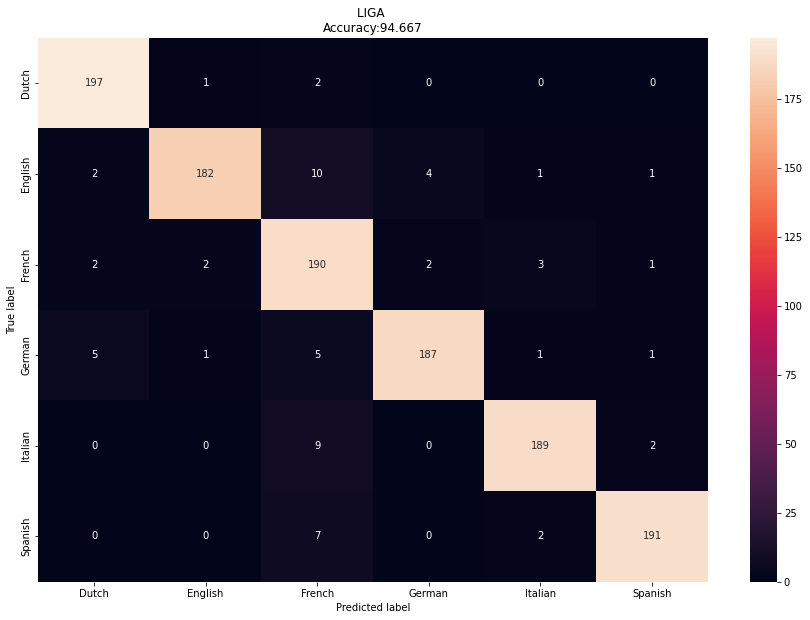

In [31]:
cm = confusion_matrix(test_df['language'].values, dataset_preds)
cm_df = pd.DataFrame(cm,index = list(lang_labels), 
                     columns = list(lang_labels))

plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('LIGA \nAccuracy:{0:.3f}'.format(acc*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
clf_report = classification_report(test_df['language'].values, dataset_preds)
print(clf_report)

              precision    recall  f1-score   support

       Dutch       0.96      0.98      0.97       200
     English       0.98      0.91      0.94       200
      French       0.85      0.95      0.90       200
      German       0.97      0.94      0.95       200
     Italian       0.96      0.94      0.95       200
     Spanish       0.97      0.95      0.96       200

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200

